In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

In [2]:
# Add the fourier_learning_ibm package to the path
import sys, pprint

sys.path.append("/home/jovyan/fourier_learning_ibm/")
pprint.pprint(sys.path)

['/home/jovyan',
 '/opt/conda/lib/python311.zip',
 '/opt/conda/lib/python3.11',
 '/opt/conda/lib/python3.11/lib-dynload',
 '',
 '/opt/conda/lib/python3.11/site-packages',
 '/home/jovyan/fourier_learning_ibm/']


In [3]:
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx
from qiskit_ibm_runtime import (
    QiskitRuntimeService,
    SamplerV2 as Sampler,
    Batch,
)
from heisenberg_graph import (
    HeisenbergModel,
    get_n_steps,
    get_graph,
    get_positions,
    get_initial_layout,
    get_prob0,
)
from qiskit_aer import AerSimulator
from qiskit_aer.noise import NoiseModel
from qiskit.quantum_info.operators import Operator
import mthree
import os
import time
from datetime import datetime, timezone
import json

In [4]:
n_qubits = 8

# total time to be simulated
# type is list so that it can be saved to json
times = np.linspace(0, 3, 50).tolist()


rng = np.random.default_rng(42)

## Create graph (Demo)

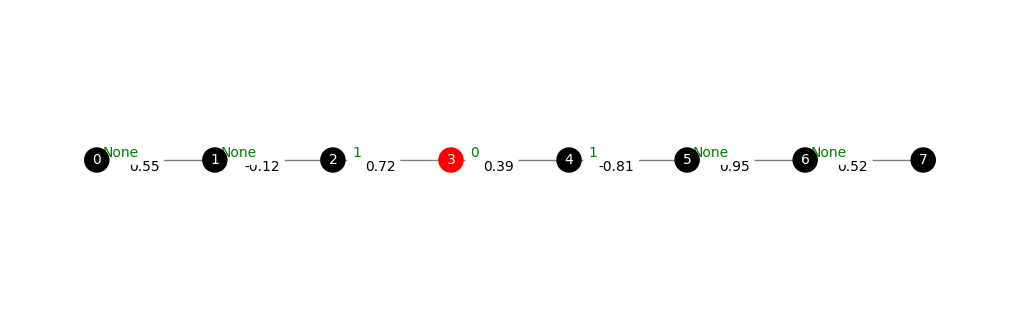

In [5]:
graph_type = "line"
G = get_graph(n_qubits, rng, graph_type)

positions = get_positions(n_qubits, graph_type)

# エッジラベルを作成
edge_J_labels = {edge: f"{G.edges[edge]['J']:.2g}" for edge in G.edges}
# edge_interaction_order_labels = {
#     edge: f"{G.edges[edge]['interaction_order']}" for edge in G.edges
# }
edge_cnot_order_labels = {edge: f"{G.edges[edge]['cnot']['order']}" for edge in G.edges}

# グラフを描画
plt.figure(figsize=(10, 3))
nx.draw(
    G,
    pos=positions,
    with_labels=True,
    node_color=["red" if G.nodes[node]["hadamard"] else "black" for node in G.nodes],
    node_size=300,
    edge_color="gray",
    font_color="white",
    font_size=10,
)

# エッジの重みを描画
nx.draw_networkx_edge_labels(
    G,
    pos=positions,
    edge_labels=edge_J_labels,
    font_size=10,
    font_color="black",
    label_pos=0.6,
    verticalalignment="top",
)

# エッジの 'interaction_order' 属性を描画
# nx.draw_networkx_edge_labels(
#     G,
#     pos=positions,
#     edge_labels=edge_interaction_order_labels,
#     font_size=10,
#     font_color="blue",
#     label_pos=0.4,
#     verticalalignment="bottom",
# )

# エッジの 'cnot' 'order' 属性を描画
nx.draw_networkx_edge_labels(
    G,
    pos=positions,
    edge_labels=edge_cnot_order_labels,
    font_size=10,
    font_color="green",
    label_pos=0.8,
    verticalalignment="bottom",
)

plt.show()

In [6]:
# Option1: Use IBM Quantum backend.
# Set up the Qiskit Runtime service (this is a one-time setup)
# QiskitRuntimeService.save_account(
#     token="YOUR_API_TOKEN",
#     channel="ibm_quantum",
# )

# Load saved credentials
service = QiskitRuntimeService()
# backend_qpu = service.least_busy(simulator=False, interactional=True)
backend_qpu = service.backend("ibm_marrakesh")

# Option2: Use local AerSimulator as the backend.
backend_sim = AerSimulator()
noise_model = NoiseModel.from_backend(backend_qpu)
backend_sim_noisy = AerSimulator(noise_model=noise_model)

print(f"Using backend QPU: {backend_qpu}")
print(f"Using backend simulator: {backend_sim}")
print(f"Using backend noisy simulator: {backend_sim_noisy}")

Using backend QPU: <IBMBackend('ibm_marrakesh')>
Using backend simulator: AerSimulator('aer_simulator')
Using backend noisy simulator: AerSimulator('aer_simulator'
             noise_model=<NoiseModel on ['reset', 'x', 'measure', 'sx', 'id', 'cz']>)


## Trotter simulation (exact)

In [7]:
phase = 0

In [8]:
probs_exact = []
heisenberg_exact = HeisenbergModel(n_qubits, G)

for k in range(len(times)):
    print(f"processing {k}")
    prob_exact = heisenberg_exact.exact_simulation(times[k], phase=phase)
    probs_exact.append(prob_exact)

processing 0
processing 1
processing 2


/opt/conda/lib/python3.11/site-packages/scipy/sparse/linalg/_dsolve/linsolve.py:412: SparseEfficiencyWarning: splu converted its input to CSC format
  warn('splu converted its input to CSC format', SparseEfficiencyWarning)
/opt/conda/lib/python3.11/site-packages/scipy/sparse/linalg/_dsolve/linsolve.py:302: SparseEfficiencyWarning: spsolve is more efficient when sparse b is in the CSC matrix format
  warn('spsolve is more efficient when sparse b '


processing 3
processing 4
processing 5
processing 6
processing 7
processing 8
processing 9
processing 10
processing 11
processing 12
processing 13
processing 14
processing 15
processing 16
processing 17
processing 18
processing 19
processing 20
processing 21
processing 22
processing 23
processing 24
processing 25
processing 26
processing 27
processing 28
processing 29
processing 30
processing 31
processing 32
processing 33
processing 34
processing 35
processing 36
processing 37
processing 38
processing 39
processing 40
processing 41
processing 42
processing 43
processing 44
processing 45
processing 46
processing 47
processing 48
processing 49


## Trotter simulation (Simulator, Noise free)

In [9]:
heisenberg_sim = HeisenbergModel(n_qubits, G, backend_sim)
circuits = []
exec_circuits = []

for k in range(len(times)):
    print(f"processing {k}")
    n_steps = get_n_steps(times[k])

    circuit, exec_circuit = heisenberg_sim.get_trotter_simulation_circuit(
        times[k], n_steps, phase=phase
    )
    circuits.append(circuit)
    exec_circuits.append(exec_circuit)

processing 0
 > n_steps: 1
processing 1
 > n_steps: 1
processing 2
 > n_steps: 1
processing 3
 > n_steps: 1
processing 4
 > n_steps: 1
processing 5
 > n_steps: 1
processing 6
 > n_steps: 1
processing 7
 > n_steps: 1
processing 8
 > n_steps: 1
processing 9
 > n_steps: 1
processing 10
 > n_steps: 1
processing 11
 > n_steps: 1
processing 12
 > n_steps: 1
processing 13
 > n_steps: 1
processing 14
 > n_steps: 1
processing 15
 > n_steps: 1
processing 16
 > n_steps: 1
processing 17
 > n_steps: 1
processing 18
 > n_steps: 1
processing 19
 > n_steps: 1
processing 20
 > n_steps: 1
processing 21
 > n_steps: 1
processing 22
 > n_steps: 1
processing 23
 > n_steps: 1
processing 24
 > n_steps: 1
processing 25
 > n_steps: 1
processing 26
 > n_steps: 1
processing 27
 > n_steps: 1
processing 28
 > n_steps: 1
processing 29
 > n_steps: 1
processing 30
 > n_steps: 1
processing 31
 > n_steps: 1
processing 32
 > n_steps: 1
processing 33
 > n_steps: 1
processing 34
 > n_steps: 1
processing 35
 > n_steps: 1
pr

In [10]:
with Batch(backend=backend_sim):
    sampler = Sampler()
    # Turn on dynamical decoupling.
    sampler.options.dynamical_decoupling.enable = True

    # Run job.
    job = sampler.run(exec_circuits)
    print(f"job_id: {job.job_id()}")

job_id: 9b9e1411-cb94-42bc-a5a3-79bb2254b4c3


/opt/conda/lib/python3.11/site-packages/qiskit_ibm_runtime/fake_provider/local_service.py:233: UserWarning: Options {'dynamical_decoupling': {'enable': True}} have no effect in local testing mode.
  warnings.warn(f"Options {options_copy} have no effect in local testing mode.")


In [11]:
# Post-processing
probs_sim = []

for result in job.result():
    prob0 = get_prob0(result, n_qubits)
    probs_sim.append(prob0)

## Trotter simulation (Simulator, Noisy)

In [12]:
heisenberg_sim_noisy = HeisenbergModel(n_qubits, G, backend_sim)
circuits = []
exec_circuits = []

for k in range(len(times)):
    n_steps = get_n_steps(times[k])

    circuit, exec_circuit = heisenberg_sim_noisy.get_trotter_simulation_circuit(
        times[k], n_steps, phase=phase
    )
    circuits.append(circuit)
    exec_circuits.append(exec_circuit)

In [13]:
with Batch(backend=backend_sim_noisy):
    sampler = Sampler()
    # Turn on dynamical decoupling.
    sampler.options.dynamical_decoupling.enable = True

    # Run job.
    job = sampler.run(exec_circuits)
    print(f"job_id: {job.job_id()}")

job_id: 332e50ee-63ab-4a05-b2c4-70e470c091e2


/opt/conda/lib/python3.11/site-packages/qiskit_ibm_runtime/fake_provider/local_service.py:233: UserWarning: Options {'dynamical_decoupling': {'enable': True}} have no effect in local testing mode.
  warnings.warn(f"Options {options_copy} have no effect in local testing mode.")


In [14]:
# Post-processing
probs_sim_noisy = []

for result in job.result():
    prob0 = get_prob0(result, n_qubits)
    probs_sim_noisy.append(prob0)

In [15]:
# Only for CP1
%cd ~/fourier_learning_ibm/

/home/jovyan/fourier_learning_ibm


In [16]:
CURRENT_TIME = (
    datetime.now(timezone.utc).isoformat(timespec="minutes").replace("+00:00", "Z")
)

path = f"./test_data/{CURRENT_TIME}"
os.makedirs(path, exist_ok=True)
print("Note: This CURRENT_TIME is used for other notebooks.")
print(f"CURRENT_TIME: {CURRENT_TIME}")
print(f"Saving data to {path}")

Note: This CURRENT_TIME is used for other notebooks.
CURRENT_TIME: 2024-12-02T15:21Z
Saving data to ./test_data/2024-12-02T15:21Z


In [17]:
# Save parameters

# Save the parameters as a JSON file
with open(f"{path}/params_text.json", "w") as f:
    json.dump(
        {
            "n_qubits": n_qubits,
            "graph_type": graph_type,
            "backend_qpu_name": backend_qpu.name,
            "phase": phase,
            "times": times,
            "count_times": len(times),
        },
        f,
    )

In [18]:
with open(f"{path}/job_ids.txt", "w") as f:
    for job_id in job.job_id():
        f.write(f"{job_id}\n")

## Trotter simulation (QPU)

In [19]:
heisenberg_qpu = HeisenbergModel(n_qubits, G, backend_qpu)
circuits_qpu = []
exec_circuits_qpu = []

initial_layout = get_initial_layout(n_qubits, graph_type, backend_qpu.name)


for k in range(len(times)):
    n_steps = get_n_steps(times[k])

    circuit, exec_circuit = heisenberg_qpu.get_trotter_simulation_circuit(
        times[k], n_steps, phase=0, initial_layout=initial_layout
    )
    circuits_qpu.append(circuit)
    exec_circuits_qpu.append(exec_circuit)

before transpile
circuit depth: 19
count_ops: OrderedDict([('cx', 26), ('rx', 10), ('rz', 10), ('rzx', 10), ('measure', 8), ('h', 2), ('barrier', 1)])


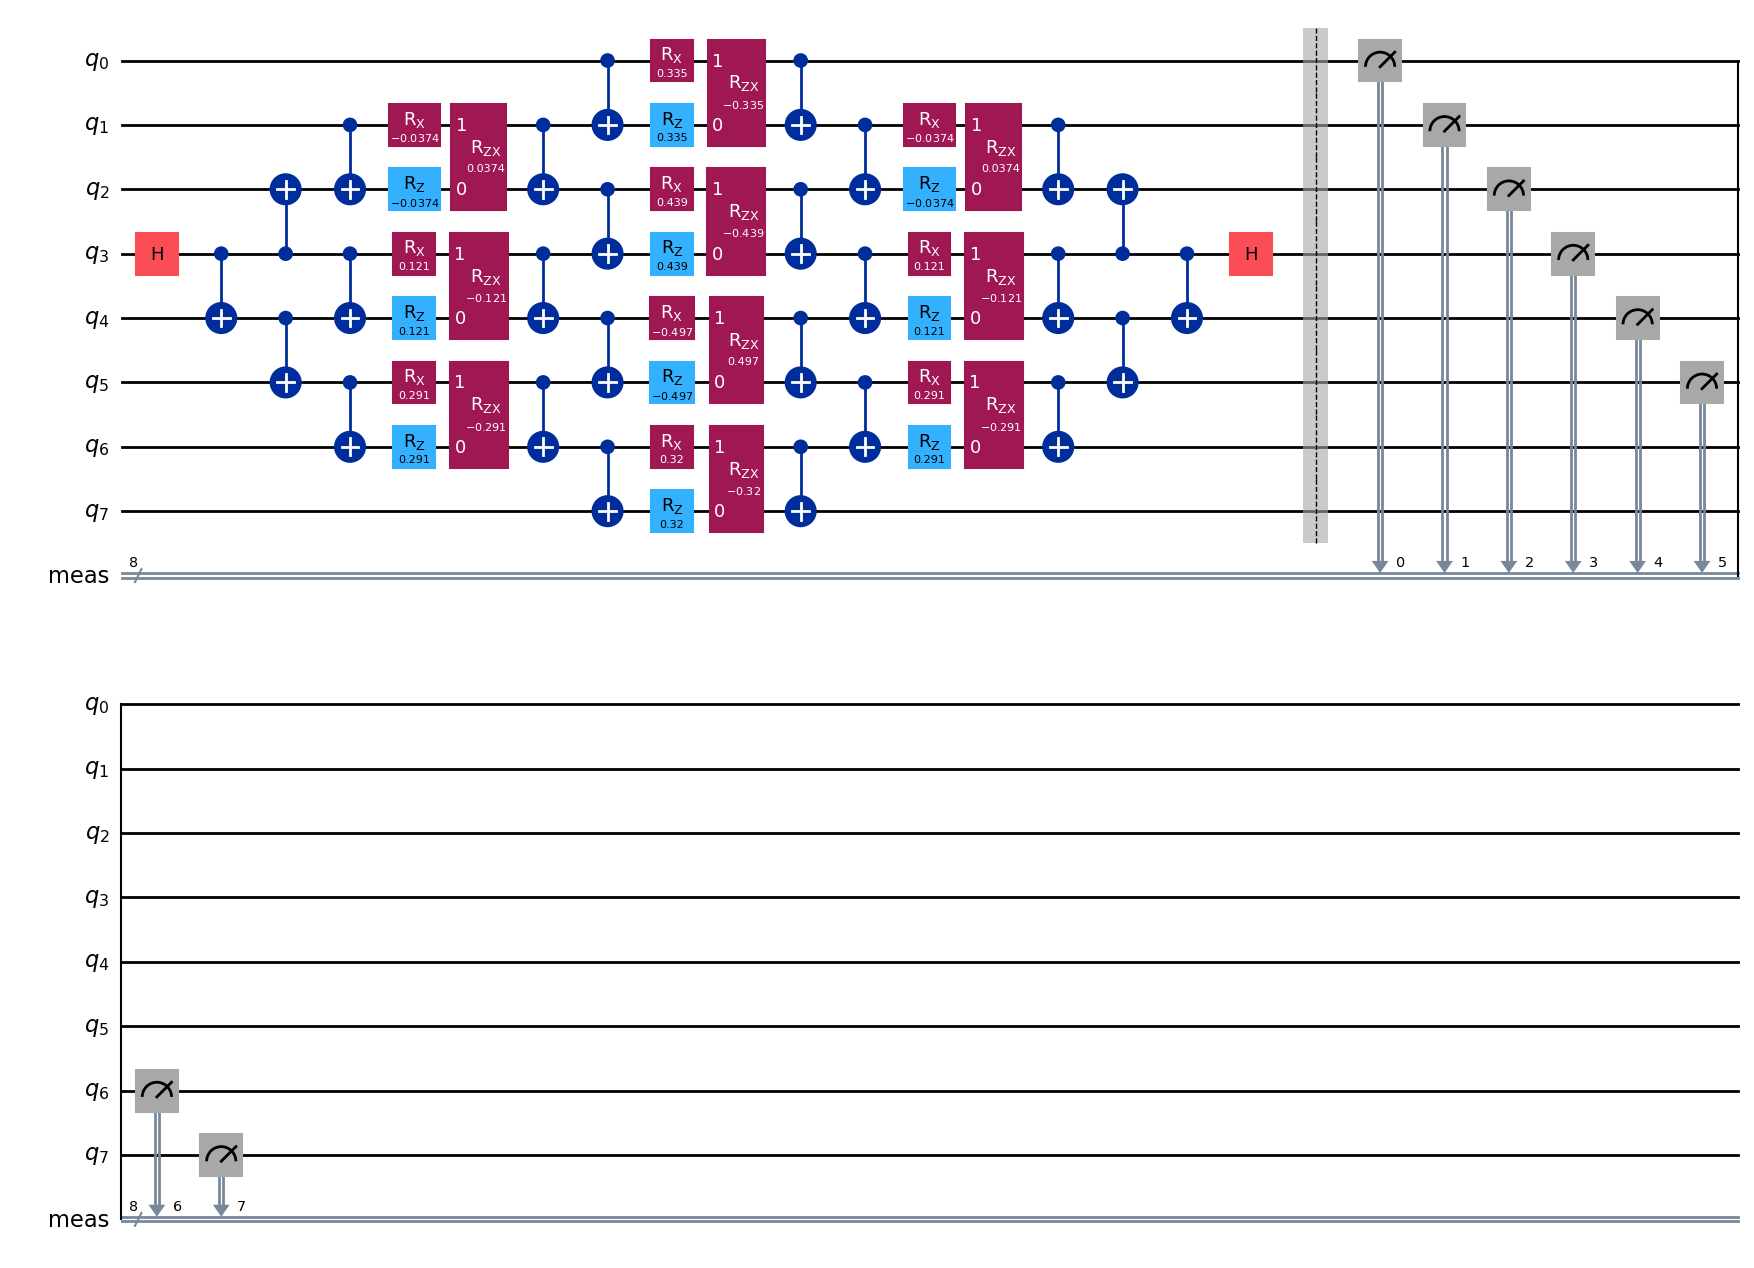

In [20]:
k = 5

print("before transpile")
print(f"circuit depth: {circuits_qpu[k].depth()}")
print(f"count_ops: {circuits_qpu[k].count_ops()}")
circuits_qpu[k].draw("mpl")

after transpile
circuit depth: 53
count_ops: OrderedDict([('sx', 89), ('rz', 75), ('cz', 36), ('measure', 8), ('x', 5), ('barrier', 1)])


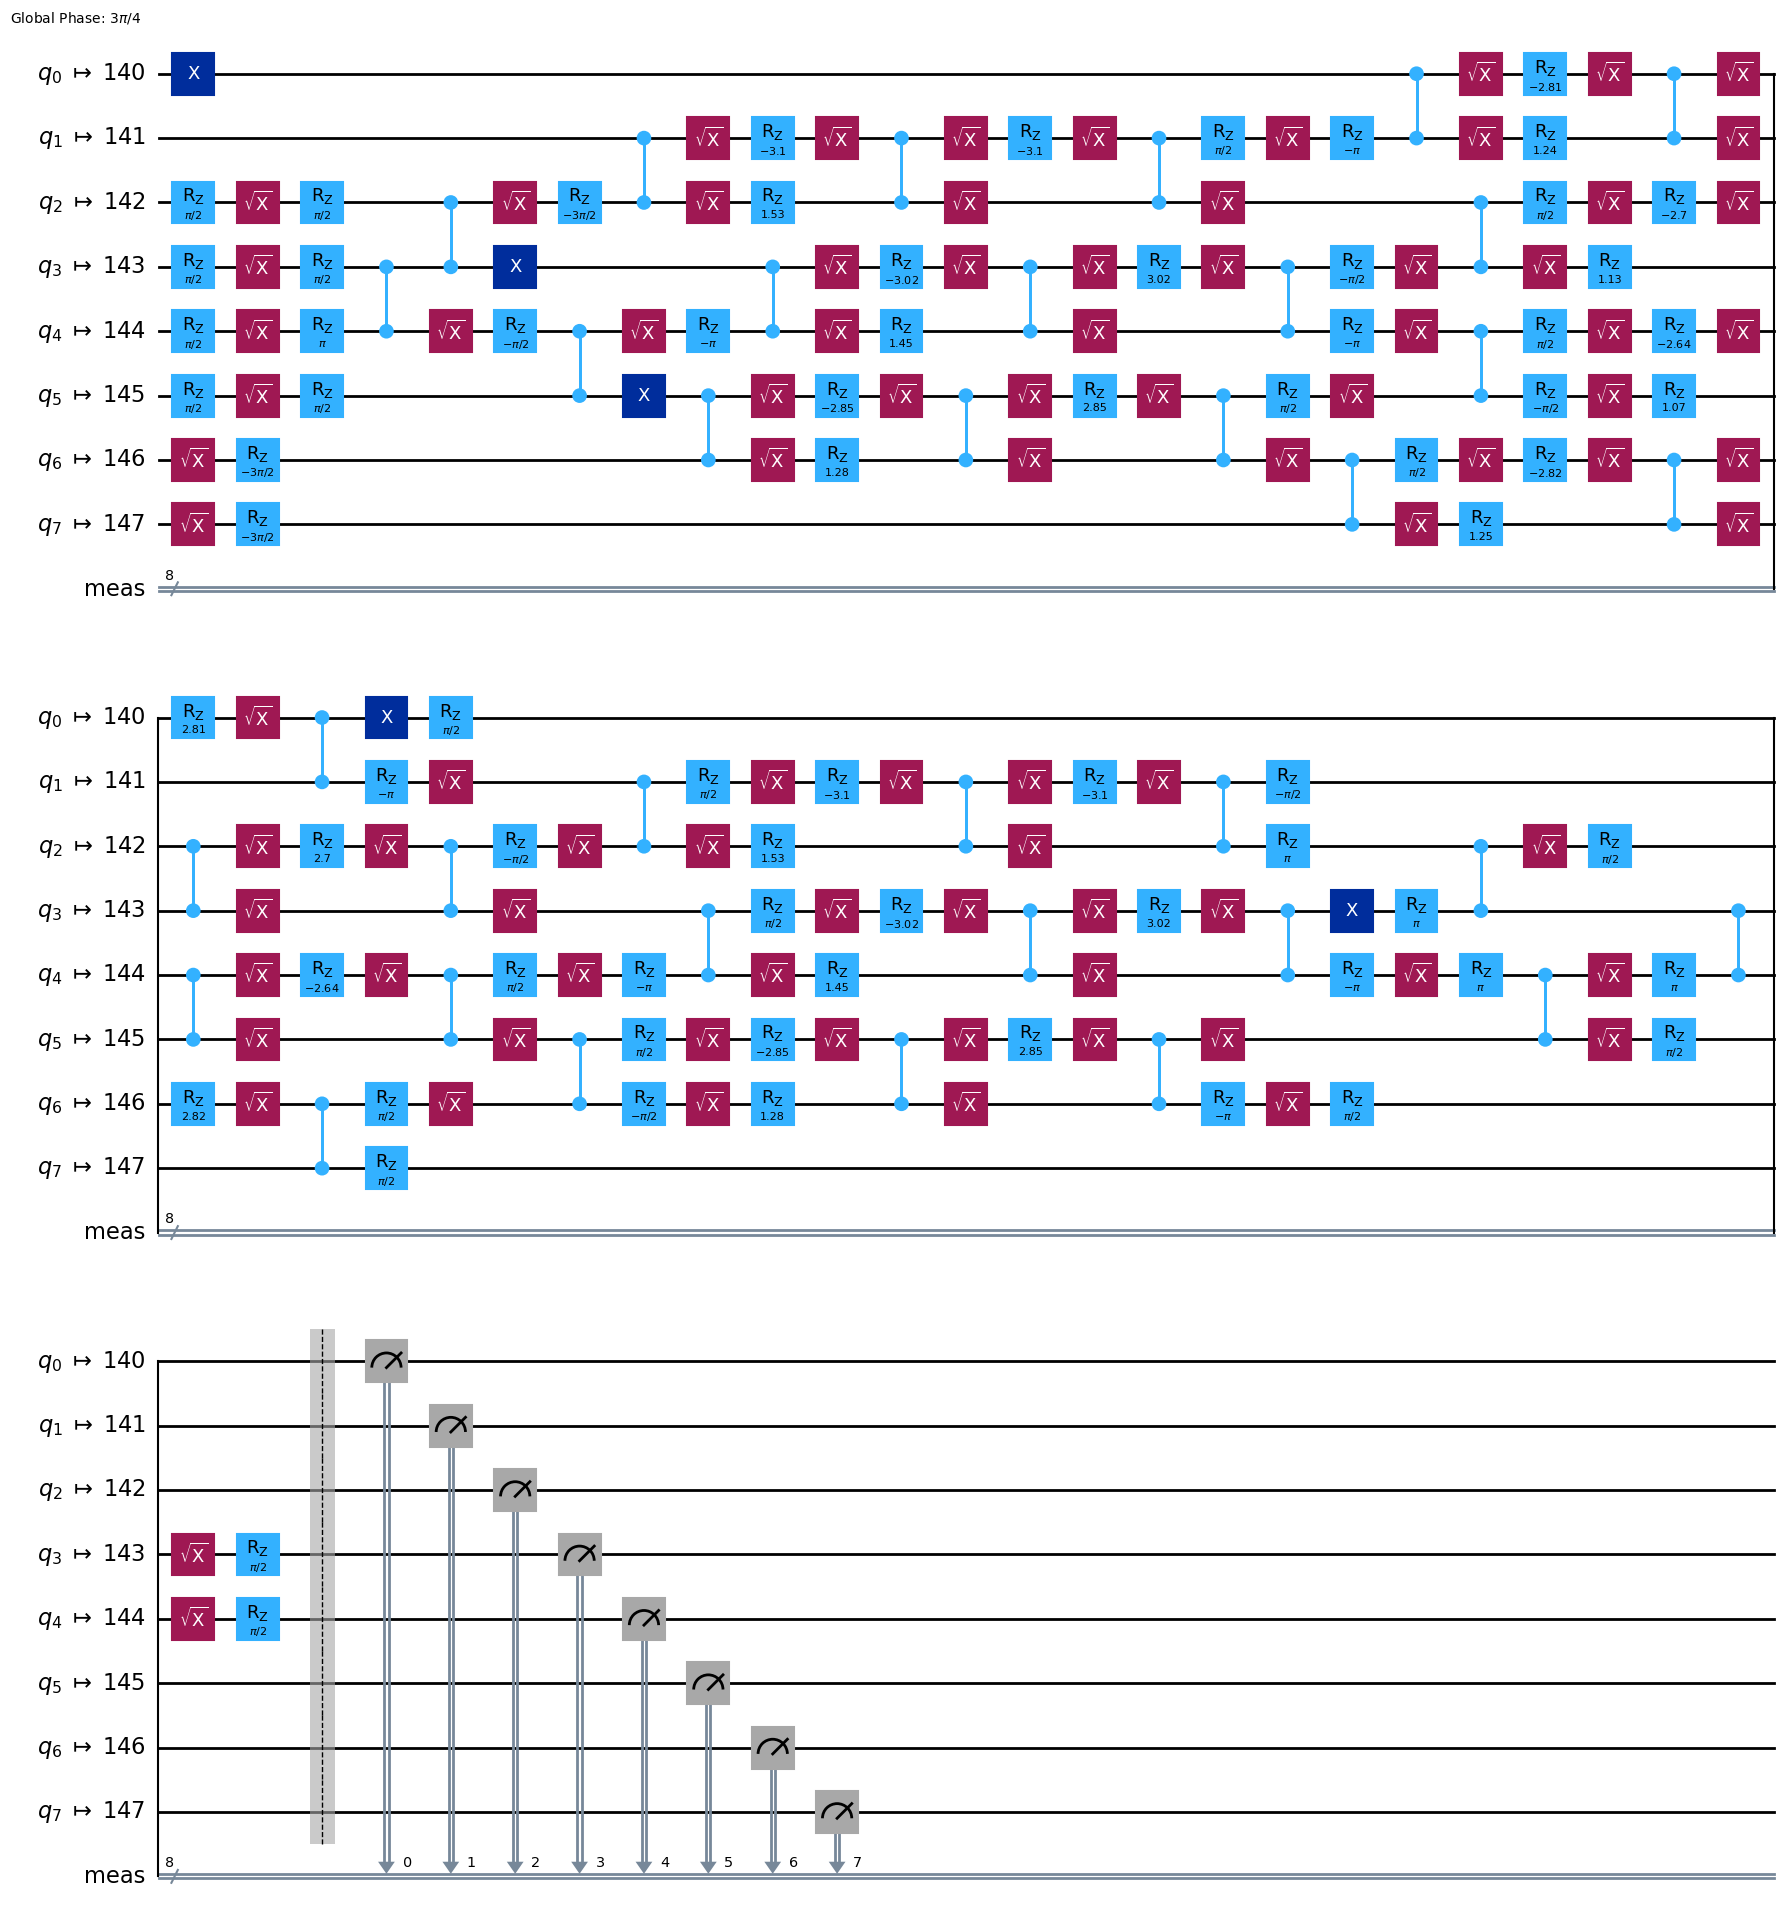

In [21]:
print("after transpile")
print(f"circuit depth: {exec_circuits_qpu[k].depth()}")
print(f"count_ops: {exec_circuits_qpu[k].count_ops()}")
exec_circuits_qpu[k].draw("mpl", idle_wires=False)

In [22]:
# Run a job in a batch
mit = mthree.M3Mitigation(backend_qpu)
with Batch(backend=backend_qpu) as batch:
    sampler = Sampler()
    mit.cals_from_system(runtime_mode=batch)
    # Turn on dynamical decoupling.
    sampler.options.dynamical_decoupling.enable = True

    # Run job.
    job = sampler.run(exec_circuits_qpu)
    print(f"job_id: {job.job_id()}")

job_id: cx6x11wrkac00085yq7g


In [25]:
batch.status()

'Pending'

In [24]:
with open(f"{path}/job_ids.txt", "w") as f:
    f.write(job.job_id())

In [26]:
# This cell can be finished after the queue is finished and the batch is started.

mit.cals_to_file(f"{path}/calibrations.json")

## Below should be run after first running

In [32]:
# Retrieve the job
with open(f"{path}/job_ids.txt", "r") as f:
    job_id = f.read()

job = service.job(job_id)

In [34]:
# Load parameters
# current_time can be found in the above cell

CURRENT_TIME = "2024-12-02T15:08Z"

path = f"./test_data/{CURRENT_TIME}"

# Load the parameters as a JSON file
with open(f"{path}/params_text.json", "r") as f:
    params = json.load(f)

n_qubits = params["n_qubits"]
graph_type = params["graph_type"]
backend_qpu_name = params["backend_qpu_name"]
phase = params["phase"]
times = params["times"]
count_times = params["count_times"]

for key, value in params.items():
    print(f"{key}: {value}")

n_qubits: 10
graph_type: line
backend_qpu_name: ibm_marrakesh
phase: 0
times: [0.0, 0.061224489795918366, 0.12244897959183673, 0.18367346938775508, 0.24489795918367346, 0.30612244897959184, 0.36734693877551017, 0.42857142857142855, 0.4897959183673469, 0.5510204081632653, 0.6122448979591837, 0.673469387755102, 0.7346938775510203, 0.7959183673469388, 0.8571428571428571, 0.9183673469387755, 0.9795918367346939, 1.0408163265306123, 1.1020408163265305, 1.163265306122449, 1.2244897959183674, 1.2857142857142856, 1.346938775510204, 1.4081632653061225, 1.4693877551020407, 1.530612244897959, 1.5918367346938775, 1.653061224489796, 1.7142857142857142, 1.7755102040816326, 1.836734693877551, 1.8979591836734693, 1.9591836734693877, 2.020408163265306, 2.0816326530612246, 2.142857142857143, 2.204081632653061, 2.2653061224489797, 2.326530612244898, 2.387755102040816, 2.4489795918367347, 2.510204081632653, 2.571428571428571, 2.63265306122449, 2.693877551020408, 2.7551020408163263, 2.816326530612245, 2.877

In [35]:
# Apply mititation
probs_qpu_nmit = []
probs_qpu_mit = []

cals_file = f"{path}/calibrations.json"
mit = mthree.M3Mitigation(backend_qpu)
mit.cals_from_file(cals_file)

for result in job.result():
    prob0_nmit, prob0_mit = get_prob0(result, n_qubits, mit)
    if prob0_mit >= 1:
        prob0_mit = 1

    probs_qpu_nmit.append(prob0_nmit)
    probs_qpu_mit.append(prob0_mit)

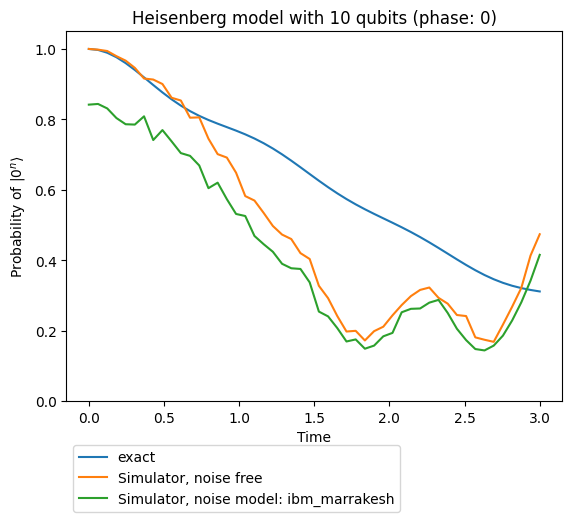

In [36]:
# Plot the results
plt.plot(times, probs_exact, label="exact")
plt.plot(times, probs_sim, label=f"Simulator, noise free")
plt.plot(times, probs_sim_noisy, label=f"Simulator, noise model: {backend_qpu.name}")
# plt.plot(times, probs_qpu_nmit, label=f"QPU: {backend_qpu.name} (no mitigation)")
# plt.plot(times, probs_qpu_mit, label=f"QPU: {backend_qpu.name} (with mitigation)")
plt.title(f"Heisenberg model with {n_qubits} qubits (phase: {phase})")
plt.ylim(0, 1.05)
plt.xlabel("Time")
plt.ylabel("Probability of $|0^n\\rangle$")
plt.legend(bbox_to_anchor=(0, -0.1), loc="upper left")
plt.show()